# Air seaparation case study

## 1. Introduction

This Jupyter Notebook develops and validates property packages for air separation units (N2, O2, Ar mixture). Two different databases have been used for comparison and validation purposes, 1) The Properties of Gasses and Liquids, 4th Ed. (1987); 2) Dowling et al., 2015, a mix of the Properties of Gasses and Liquids 3rd Ed. and NIST webbook. To demonstrate the successful implementation of the property package for separation purposes, we will study a flash unit, representing a tray inside an air separation unit. Using the flash case study, we will perform three simulations in the 2-phase region, vapor region, and liquid region. These simulations will validate the parameter database with thermodynamically consistent phase equilibria calculations for a range of conditions. Additionally, a sensitivity study is performed over the influence of temperature in the vapor-liquid split.

### 1.1 Tutorial objectives

The goals of this tutorial are:

* Utilize the mixer and flash unit models.
* Utilize the Generic Property Package, which provides a flexible platform for users to build property packages by calling upon libraries of modular sub-models to build up complex property calculations with the least effort possible.
* Demonstrate the manual initialization approach, including the use of the propagate_state method in idaes/core/util/initialization
* Fix state variables for different conditions and initialize and solve the flowsheet for these conditions.
* Demonstrate the sensitivity of the two-phase flash solution to parameter values and the importance of getting good values for these.
* Create sensitivity analysis and create a plot from the results
* Create two different flowsheet models in the same notebook with two different parameter blocks.

## 2. Problem Statement

Figure 1 shows the process flowsheet that we will be using for this module. We will mix three streams of a mixture of nitrogen, oxygen, and nitrogen. The compositions of the streams were extracted from *A framework for efficient large scale equation-oriented flowsheet optimization*, Alexander W. Dowling and Lorenz T. Biegler, 2014

![](Air_flash.png)

The flash unit model, F101, represents the top tray of a low-pressure column. The stream LowP_1 is the feed of vapor stream from the low-pressure column, while the streams HighP_1 and HighP_2 are the recycle streams coming from the high-pressure column. We will utilize the Peng-Robinson equation of state for this flowsheet. The property package required for this module is available in the property example directory:

* idaes\generic_models\properties\core\examples\ASU_PR.py 

The state variables chosen for the property package are **component mole fractions (mole_frac_comp), molar flow (flow_mol), temperature (temperature), and pressure (pressure)**. The components considered are **nitrogen, oxygen, and argon**. 

In this example, we will simulate the following cases:

* Case 1: Adiabatic flash unit calculation in the 2-phase region.
* Case 2: Flash unit calculation in the vapor region.
* Case 3: Flash unit calculation in the liquid region.
* Sensitivity Analysis 1: Vapor-liquid split with respect to temperature
* Sensitivity Analysis 2: Thermodynamic models and parameters.

## 2.1 Setting up the problem in IDAES

In the next cell, we will be importing the necessary components from Pyomo and IDAES.

In [1]:
# Import objects from pyomo package
from pyomo.environ import (ConcreteModel,
                           SolverFactory,
                           TransformationFactory,
                           value,
                           units as pyunits)

from pyomo.network import Arc

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

# Import idaes logger to set output levels
import idaes.logger as idaeslog

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Add properties parameter blocks to the flowsheet with specifications
from idaes.generic_models.properties.core.examples.ASU_PR import configuration as configuration_1

# Import unit models from the model library
from idaes.generic_models.unit_models import Mixer, Flash

### 2.1 Building the flowsheet 

In the next cell, we will first create a model and attach a flowsheet to it. We then introduce the unit models and connect them through an arc and analyze the degrees of freedom of the flowsheet and how many variables we need to fix.

In [2]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration_1)

m.fs.M101 = Mixer(default={"property_package": m.fs.props,
                           "inlet_list": ["LowP_1","HighP_1","HighP_2"]})

m.fs.F101 = Flash(default={"property_package": m.fs.props,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

# Create streams to define connectivity between unit models
m.fs.s01 = Arc(source=m.fs.M101.outlet, destination=m.fs.F101.inlet)

# Expand arcs
TransformationFactory("network.expand_arcs").apply_to(m)

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 20


### 2.2 Create solver object 

In [3]:
# Solve the simulation using ipopt
# Note: If the degrees of freedom = 0, we have a square problem
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

## 3 Case 1: Flash unit calculation in the 2-phase region.

For this tutorial, we will solve a series of case studies by changing the temperature and heat duty to evaluate the temperature's importance and the difference in the vapor fraction of the flash column.

## 3.1 Fix initial conditions

The streams' compositions were extracted from *A framework for efficient large scale equation-oriented flowsheet optimization*, Alexander W. Dowling and Lorenz T. Biegler, 2014. The streams' temperature was fixed to match a 2-phase region with a heat duty of the Flash = 0.

In [4]:
m.fs.M101.LowP_1.mole_frac_comp[0, "nitrogen"].fix(0.9814)
m.fs.M101.LowP_1.mole_frac_comp[0, "argon"].fix(0.0106)
m.fs.M101.LowP_1.mole_frac_comp[0, "oxygen"].fix(0.0080)
m.fs.M101.LowP_1.flow_mol[0].fix(1.4667)
m.fs.M101.LowP_1.temperature.fix(77.430)
m.fs.M101.LowP_1.pressure.fix(101000)

m.fs.M101.HighP_1.mole_frac_comp[0, "nitrogen"].fix(0.9942)
m.fs.M101.HighP_1.mole_frac_comp[0, "argon"].fix(0.0014)
m.fs.M101.HighP_1.mole_frac_comp[0, "oxygen"].fix(0.0043)
m.fs.M101.HighP_1.flow_mol[0].fix(0.0486)
m.fs.M101.HighP_1.temperature.fix(84.0070)
m.fs.M101.HighP_1.pressure.fix(204630)

m.fs.M101.HighP_2.mole_frac_comp[0, "nitrogen"].fix(0.9832)
m.fs.M101.HighP_2.mole_frac_comp[0, "argon"].fix(0.0032)
m.fs.M101.HighP_2.mole_frac_comp[0, "oxygen"].fix(0.0135)
m.fs.M101.HighP_2.flow_mol[0].fix(0.7134)
m.fs.M101.HighP_2.temperature.fix(84.0070)
m.fs.M101.HighP_2.pressure.fix(204630)

# Fix unit models operating conditions
# Fix F101 Flash outlet temperature
m.fs.F101.deltaP.fix(0)
m.fs.F101.heat_duty[0].fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [5]:
assert DOF_final == 0

### 3.2 Flowsheet Initialization

IDAES includes pre-written initialization routines for all unit models. We will initialize the units in order using the propagate_state method in idaes/core/util/initialization. This method propagates values between Ports along Arcs. We will propagate the values between the mixer M101 and the flash unit F101 along the stream S01.

In [6]:
m.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m.fs.s01)
m.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

### 3.3 Run Simulation

In [7]:
result = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

In [8]:
from pyomo.opt import TerminationCondition, SolverStatus

# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

### 3.4 Results

In [9]:
# Display output report
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Duty : 0.0000 :  True : (None, None)
    Pressure Change : 0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                    2.2286       1.6029       0.62575  
    mole_frac_comp nitrogen    0.98229      0.98901       0.96508  
    mole_frac_comp argon     0.0080309    0.0055854      0.014295  
    mole_frac_comp oxygen    0.0096802    0.0054079      0.020624  
    temperature                 77.431       77.431        77.431  
    pressure                1.0100e+05   1.0100e+05    1.0100e+05  


As we can see from the Flash report with a Heat Duty = 0, we have a liquid outlet of 0.658 and a vapor outlet of 1.603. This results in a vapor fraction of 0.72, which was expected.

In [10]:
import pytest

# Check results
assert m.fs.F101.heat_duty[0].value == pytest.approx(0.0, abs=1e-1)

assert m.fs.F101.liq_outlet.flow_mol[0].value == pytest.approx(0.63350, abs=1e-2)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.96525, abs=1e-3)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.014242, abs=1e-3)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.020512, abs=1e-3)
assert m.fs.F101.liq_outlet.temperature[0].value == pytest.approx(77.430, abs=1e-2)
assert m.fs.F101.liq_outlet.pressure[0].value == pytest.approx(101000, abs=1)

assert m.fs.F101.vap_outlet.flow_mol[0].value == pytest.approx(1.5951, abs=1e-2)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.98906, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.0055642, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.0053782, abs=1e-3)
assert m.fs.F101.vap_outlet.temperature[0].value == pytest.approx(77.430, abs=1e-2)
assert m.fs.F101.vap_outlet.pressure[0].value == pytest.approx(101000, abs=1)

## 4. Case 2: Flash unit calculation in the vapor region.

### 4.1 Fix initial conditions

We unfix the heat duty and fix the flash outlet to a temperature where we estimate we will only obtain vapor as the outlet.

In [11]:
m.fs.F101.heat_duty[0].unfix()
m.fs.F101.vap_outlet.temperature.fix(80)

### 4.2 Flowsheet Initialization

In [12]:
m.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m.fs.s01)
m.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

### 4.3 Run Simulation

In [13]:
result = solver.solve(m, tee=False)

### 4.4 Results

In [14]:
# Display output report
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Duty : 3668.8 : False : (None, None)
    Pressure Change : 0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                    2.2286       2.2286    5.2025e-06  
    mole_frac_comp nitrogen    0.98229      0.98229       0.94329  
    mole_frac_comp argon     0.0080311    0.0080310      0.020284  
    mole_frac_comp oxygen    0.0096804    0.0096804      0.036423  
    temperature                 77.431       80.000        80.000  
    pressure                1.0100e+05   1.0100e+05    1.0100e+05  


As expected the outlet of the flash is vapor phase only.

In [15]:
#Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

In [16]:
# Check results
assert m.fs.F101.heat_duty[0].value == pytest.approx(3668.5, abs=1e1)

assert m.fs.F101.liq_outlet.flow_mol[0].value == pytest.approx(0.0, abs=1e-2)

assert m.fs.F101.vap_outlet.flow_mol[0].value == pytest.approx(2.2286, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.98229, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.0080309, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.0096802, abs=1e-3)
assert m.fs.F101.vap_outlet.temperature[0].value == pytest.approx(80.000, abs=1e-2)
assert m.fs.F101.vap_outlet.pressure[0].value == pytest.approx(101000, abs=1)

## 5 Case 3: Flash unit calculation in the liquid region.

### 5.1 Fix initial conditions

We now fix the flash outlet to a temperature where we estimate we will only obtain liquid as the outlet

In [17]:
m.fs.F101.vap_outlet.temperature.fix(68)

### 5.2 Flowsheet Initialization

In [18]:
m.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m.fs.s01)
m.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

### 5.3 Run Simulation

In [19]:
result = solver.solve(m, tee=False)

### 5.4 Results

In [20]:
# Display output report
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : -10025. : False : (None, None)
    Pressure Change :  0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                    2.2286   0.00044690        2.2282  
    mole_frac_comp nitrogen    0.98229      0.99438       0.98229  
    mole_frac_comp argon     0.0080310    0.0031076     0.0080320  
    mole_frac_comp oxygen    0.0096803    0.0025125     0.0096817  
    temperature                 77.431       68.000        68.000  
    pressure                1.0100e+05   1.0100e+05    1.0100e+05  


As expected the outlet of the flash is liquid phase only.

In [21]:
# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

In [22]:
# Check results
assert m.fs.F101.heat_duty[0].value == pytest.approx(-10027., abs=1e1)

assert m.fs.F101.liq_outlet.flow_mol[0].value == pytest.approx(2.2285, abs=1e-2)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.98229, abs=1e-4)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "argon"].value == pytest.approx( 0.00803, abs=1e-4)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.0096805, abs=1e-4)
assert m.fs.F101.liq_outlet.temperature[0].value == pytest.approx(68.000, abs=1e-2)
assert m.fs.F101.liq_outlet.pressure[0].value == pytest.approx(101000, abs=1)

assert m.fs.F101.vap_outlet.flow_mol[0].value == pytest.approx(0.000, abs=1e-2)

## 6 Sensitivity Analysis 1: Vapor-liquid split with respect to temperature

The property example contains two dictionaries:
* configuration 1: contains parameters obtained from The Properties of Gases and Liquids (1987) 4th edition and NIST.
* configuration 2: contains parameters used in A framework for efficient large scale equation-oriented flowsheet optimization (2015) Dowling. The parameters are extracted from Properties of Gases and Liquids (1977) 3rd edition for Antoine's vapor equation and acentric factors and converted values from the Properties of Gases and Liquids (1977) 3rd edition

## 6.1 Fix initial conditions

We will first fix a temperature close to the temperature of the sensitivity analysis's start and initialize the model.

In [23]:
m.fs.F101.vap_outlet.temperature.fix(77.01)

### 6.2 Flowsheet Initialization

In [24]:
m.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m.fs.s01)
m.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

### 6.3 Run Simulation

We will run a few cases with different parameter values and look at the effect on the vapour fraction as a function of T.. For the sensitivity analysis, we will create a vector of temperatures, solve the model, and store the vapor fraction. The user can make decisions on what values to store depending on the variable or variables to study.

In [25]:
T = np.linspace(77.01, 78, 19)
x1 = []
T1 = []
count = 1

for i in range(len(T)):
    m.fs.F101.vap_outlet.temperature[0].fix(T[i])
    # solve the model
    status = solver.solve(m, tee=False)
    if status.solver.termination_condition == TerminationCondition.optimal:
        print('Case: ',count,' Optimal. Temp = {:.2f}'.format(T[i]),' K')
        x1.append(value(m.fs.F101.vap_outlet.flow_mol[0])/value(m.fs.F101.inlet.flow_mol[0])) 
        T1.append(T[i])
    else:
        print('Case: ',count,' Failed to solve. Temp = {:.2f}'.format(T[i]),' K')
    count += 1

Case:  1  Optimal. Temp = 77.01  K
Case:  2  Optimal. Temp = 77.06  K
Case:  3  Optimal. Temp = 77.12  K
Case:  4  Optimal. Temp = 77.18  K
Case:  5  Optimal. Temp = 77.23  K
Case:  6  Optimal. Temp = 77.28  K
Case:  7  Optimal. Temp = 77.34  K
Case:  8  Optimal. Temp = 77.40  K
Case:  9  Optimal. Temp = 77.45  K
Case:  10  Optimal. Temp = 77.50  K
Case:  11  Optimal. Temp = 77.56  K
Case:  12  Optimal. Temp = 77.62  K
Case:  13  Optimal. Temp = 77.67  K
Case:  14  Optimal. Temp = 77.72  K
Case:  15  Optimal. Temp = 77.78  K
Case:  16  Optimal. Temp = 77.84  K
Case:  17  Optimal. Temp = 77.89  K
Case:  18  Optimal. Temp = 77.94  K
Case:  19  Optimal. Temp = 78.00  K


### 6.4 Results

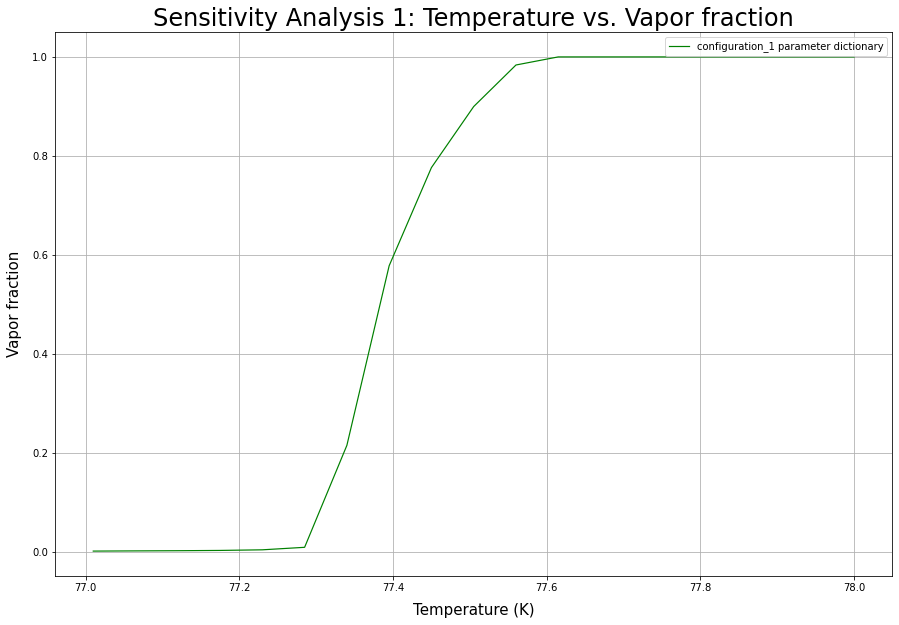

In [26]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(T1, x1,"g",label="configuration_1 parameter dictionary",linewidth=1.2)
ax.set_xlabel('Temperature (K)',fontsize=15, labelpad=10)
ax.set_ylabel('Vapor fraction',fontsize=15, labelpad=10)
ax.legend(fontsize=15)
plt.title("Sensitivity Analysis 1: Temperature vs. Vapor fraction",fontsize=24)
ax.grid()
plt.legend()
plt.show()

With the results obtained, we can now set the flash's temperature to get an outlet with a specific desired vapor-liquid split. We will use this data later after we have some other results to compare it to. 

## 7. Sensitivity Analysis 2: Thermodynamic models and parameters.

## 7.1 Building a second flowsheet 

Create a second model utilizing parameters and equations from *A framework for efficient large scale equation-oriented flowsheet optimization* (2015) Dowling. We need to import the parameter block dictionary **configuration_Dowling_2015** and create a flowsheet as we did in the example above. We will utilize the same flowsheet configuration.

In [27]:
from idaes.generic_models.properties.core.examples.ASU_PR import configuration_Dowling_2015 as configuration_2

m1 = ConcreteModel()

m1.fs = FlowsheetBlock(default={"dynamic": False}) 

m1.fs.props = GenericParameterBlock(default=configuration_2)

m1.fs.M101 = Mixer(default={"property_package": m1.fs.props,
                           "inlet_list": ["LowP_1","HighP_1","HighP_2"]})

m1.fs.F101 = Flash(default={"property_package": m1.fs.props,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m1.fs.s01 = Arc(source=m1.fs.M101.outlet, destination=m1.fs.F101.inlet)

TransformationFactory("network.expand_arcs").apply_to(m1)

## 7.2 Fix initial conditions

The compositions of the streams were extracted from *A framework for efficient large scale equation-oriented flowsheet optimization*, Alexander W. Dowling and Lorenz T. Biegler, 2014. The temperature of the streams was fixed to match a 2-phase region with a heat duty of the Flash = 0.

In [28]:
m1.fs.M101.LowP_1.mole_frac_comp[0, "nitrogen"].fix(0.9814)
m1.fs.M101.LowP_1.mole_frac_comp[0, "argon"].fix(0.0106)
m1.fs.M101.LowP_1.mole_frac_comp[0, "oxygen"].fix(0.0080)
m1.fs.M101.LowP_1.flow_mol[0].fix(1.4667)
m1.fs.M101.LowP_1.temperature.fix(77.6601)
m1.fs.M101.LowP_1.pressure.fix(101000)

m1.fs.M101.HighP_1.mole_frac_comp[0, "nitrogen"].fix(0.9942)
m1.fs.M101.HighP_1.mole_frac_comp[0, "argon"].fix(0.0014)
m1.fs.M101.HighP_1.mole_frac_comp[0, "oxygen"].fix(0.0043)
m1.fs.M101.HighP_1.flow_mol[0].fix(0.0486)
m1.fs.M101.HighP_1.temperature.fix(84.0070)
m1.fs.M101.HighP_1.pressure.fix(204630)

m1.fs.M101.HighP_2.mole_frac_comp[0, "nitrogen"].fix(0.9832)
m1.fs.M101.HighP_2.mole_frac_comp[0, "argon"].fix(0.0032)
m1.fs.M101.HighP_2.mole_frac_comp[0, "oxygen"].fix(0.0135)
m1.fs.M101.HighP_2.flow_mol[0].fix(0.7134)
m1.fs.M101.HighP_2.temperature.fix(84.0070)
m1.fs.M101.HighP_2.pressure.fix(204630)

# Fix unit models operating conditions
m1.fs.F101.deltaP.fix(0)
m1.fs.F101.heat_duty[0].fix(0)
DOF_final = degrees_of_freedom(m1)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


### 7.3 Flowsheet Initialization

The flowsheet is now complete, and we have a square problem (degrees of freedom = 0). We now initialize and solve adiabatic the model at the temperature stated in the paper.  

In [29]:
m1.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m1.fs.s01)
m1.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

### 7.4 Run Simulation of adiabatic flash unit calculation in the 2-phase region.

In [30]:
result = solver.solve(m, tee=False)

In [31]:
# Check results
assert m1.fs.F101.heat_duty[0].value == pytest.approx(0.0, abs=1e1)

assert m1.fs.F101.liq_outlet.flow_mol[0].value == pytest.approx(0.61582, abs=1e-2)
assert m1.fs.F101.liq_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.96535, abs=1e-3)
assert m1.fs.F101.liq_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.014167, abs=1e-3)
assert m1.fs.F101.liq_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.020480, abs=1e-3)
assert m1.fs.F101.liq_outlet.temperature[0].value == pytest.approx(77.535, abs=1e-2)
assert m1.fs.F101.liq_outlet.pressure[0].value == pytest.approx(101000, abs=1)

assert m1.fs.F101.vap_outlet.flow_mol[0].value == pytest.approx(1.6128, abs=1e-2)
assert m1.fs.F101.vap_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.98875, abs=1e-3)
assert m1.fs.F101.vap_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.0056891, abs=1e-3)
assert m1.fs.F101.vap_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.0055588, abs=1e-3)
assert m1.fs.F101.vap_outlet.temperature[0].value == pytest.approx(77.535, abs=1e-2)
assert m1.fs.F101.vap_outlet.pressure[0].value == pytest.approx(101000, abs=1)

### 7.5 Results of adiabatic flash unit calculation in the 2-phase region.

In [32]:
# Display output report
m1.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Duty : 0.0000 :  True : (None, None)
    Pressure Change : 0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                    2.2286       1.6132       0.61538  
    mole_frac_comp nitrogen    0.98229      0.98875       0.96535  
    mole_frac_comp argon     0.0080309    0.0056897      0.014169  
    mole_frac_comp oxygen    0.0096802    0.0055595      0.020483  
    temperature                 77.535       77.535        77.535  
    pressure                1.0100e+05   1.0100e+05    1.0100e+05  


As we can see from the Flash report with a Heat Duty = 0, we have a liquid outlet of 0.615 and a vapor outlet of 1.612. This results in a vapor fraction of 0.70. However, the temperature of our two models is different. We will create two python variables to store the vapor flow and temperature results, which we will use on the plot.

In [33]:
T_paper = m1.fs.F101.vap_outlet.temperature[0].value
x_paper = m1.fs.F101.vap_outlet.flow_mol[0].value/m1.fs.F101.inlet.flow_mol[0].value

### 7.6 Flowsheet Initialization for sensitivity analysis

In [34]:
m1.fs.F101.heat_duty[0].unfix()
m1.fs.F101.vap_outlet.temperature.fix(77.01)

m1.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m1.fs.s01)
m1.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

### 7.7 Run Simulation

In [35]:
T = np.linspace(77, 78, 19)
x2 = []
T2 = []
count = 1

for i in range(len(T)):
    m1.fs.F101.vap_outlet.temperature[0].fix(T[i])
    # solve the model
    status = solver.solve(m1, tee=False)
   
    if status.solver.termination_condition == TerminationCondition.optimal:
        print('Case: ',count,' Optimal. Temp = {:.2f}'.format(T[i]),' K')
        x2.append(value(m1.fs.F101.vap_outlet.flow_mol[0])/value(m1.fs.F101.inlet.flow_mol[0])) 
        T2.append(T[i])
    else:
        print('Case: ',count,' Failed to solve. Temp = {:.2f}'.format(T[i]),' K')
    count += 1

Case:  1  Optimal. Temp = 77.00  K
Case:  2  Optimal. Temp = 77.06  K
Case:  3  Optimal. Temp = 77.11  K
Case:  4  Optimal. Temp = 77.17  K
Case:  5  Optimal. Temp = 77.22  K
Case:  6  Optimal. Temp = 77.28  K
Case:  7  Optimal. Temp = 77.33  K
Case:  8  Optimal. Temp = 77.39  K
Case:  9  Optimal. Temp = 77.44  K
Case:  10  Optimal. Temp = 77.50  K
Case:  11  Optimal. Temp = 77.56  K
Case:  12  Optimal. Temp = 77.61  K
Case:  13  Optimal. Temp = 77.67  K
Case:  14  Optimal. Temp = 77.72  K
Case:  15  Optimal. Temp = 77.78  K
Case:  16  Optimal. Temp = 77.83  K
Case:  17  Optimal. Temp = 77.89  K
Case:  18  Optimal. Temp = 77.94  K
Case:  19  Optimal. Temp = 78.00  K


### 7.8 Results

Now we will plot the results

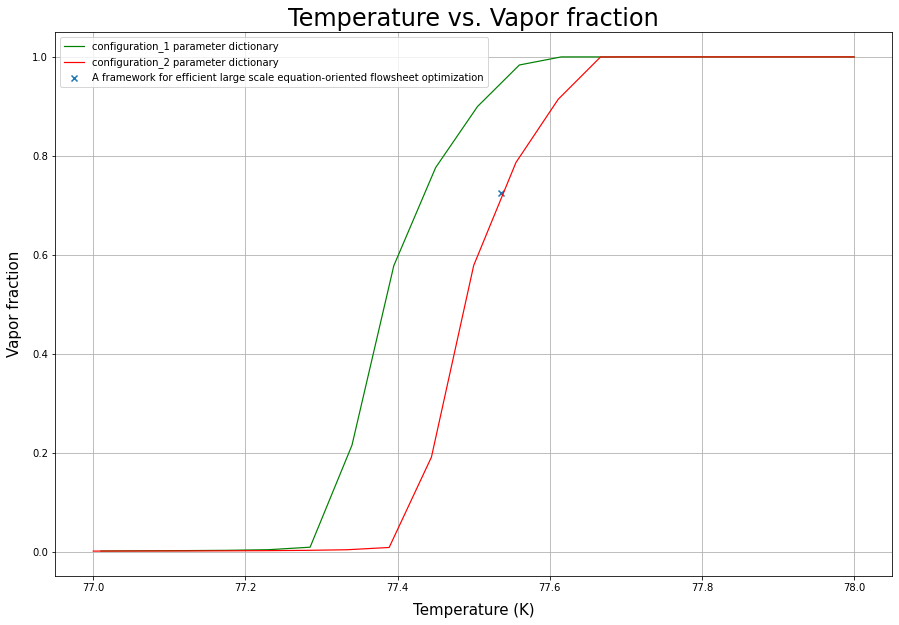

In [36]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(T1, x1,"g",label="configuration_1 parameter dictionary",linewidth=1.2)
ax.plot(T2, x2,"r",label="configuration_2 parameter dictionary",linewidth=1.2)
plt.scatter(T_paper, x_paper,marker='x',label="A framework for efficient large scale equation-oriented flowsheet optimization")
ax.set_xlabel('Temperature (K)',fontsize=15, labelpad=10)
ax.set_ylabel('Vapor fraction',fontsize=15, labelpad=10)
ax.legend(fontsize=15)
plt.title("Temperature vs. Vapor fraction",fontsize=24)
ax.grid()
plt.legend()
plt.show()

From the plot, we can note the influence the thermodynamic equations and coefficients have. We can observe that a 0.2 K difference may account for a 0 to a 0.6 vapor fraction difference.

More often than not, as users, we do not identify the thermodynamics and parameters used in equations used to solve problems. In this case, we may not have looked at the parameter values to realize what changed. We want to mention and note how significant the effect of the property package is. When creating parameter blocks, the parameter values are fitted to specific data ranges, and users should be check to see if the data used covers the range of interest. Users can (and often should) fit their parameters wherever possible, focusing on the range of interest conditions of an individual problem.